In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
import json

sys.path.append(os.path.abspath("../src"))

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from utils import generate_abnormal_samples, generate_normal_samples, error_summary


MODEL_DIR = os.path.join(os.path.dirname(os.getcwd()), "models")
os.makedirs(MODEL_DIR, exist_ok=True)

Samples rounded to: 300

----- RULE + IF PERFORMANCE -----
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       700
           1       0.70      1.00      0.82       300

    accuracy                           0.87      1000
   macro avg       0.85      0.91      0.86      1000
weighted avg       0.91      0.87      0.88      1000



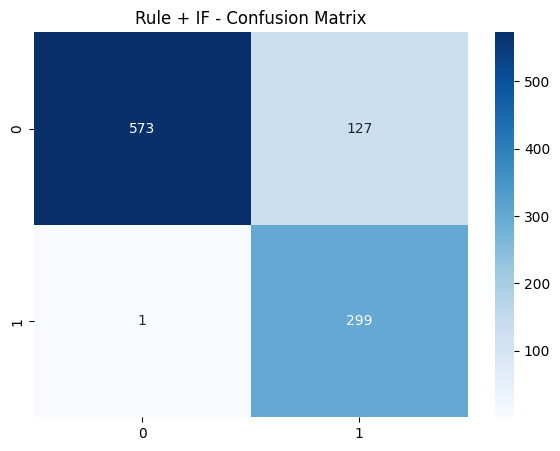

----- Error Summary (Rule + IF) -----
            Matching Samples  Total Samples  Matching Rate
Error Type                                                
Ca0_high                  50             50         100.00
Ca0_low                   50             50         100.00
Q_high                    50             50         100.00
Q_low                     50             50         100.00
T_high                    50             50         100.00
T_low                     49             50          98.00
none                     573            700          81.86


In [2]:
# 1. TRAIN DATA GENERATION (NORMAL)
initial_samples = generate_normal_samples(n_samples=10000)
X_train = initial_samples.iloc[:, :-2]

# 2. TEST DATA GENERATION (ANOMALY + NORMAL)
abnormal_test_samples = generate_abnormal_samples(n_samples=300)
normal_test_samples = generate_normal_samples(n_samples=700)
test_samples = (
    pd.concat([abnormal_test_samples, normal_test_samples], axis=0)
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)
X_test = test_samples.iloc[:, :-2]
true_labels = test_samples.is_anomaly.values
error_type = test_samples.anomaly_type.values

# 3. Q ANOMALY DECISION RULE BASED FILTERING
MARGIN = 0.1
Q_MIN, Q_MAX = 1 - MARGIN, 1.5 + MARGIN

train_q_mask = (X_train["Q"] >= Q_MIN) & (X_train["Q"] <= Q_MAX)
test_q_mask = (X_test["Q"] >= Q_MIN) & (X_test["Q"] <= Q_MAX)

train_q_anomaly = ~train_q_mask
test_q_anomaly = ~test_q_mask

X_train_qfiltered = X_train.loc[train_q_mask].drop(columns=["Q"])
X_test_qfiltered = X_test.loc[test_q_mask].drop(columns=["Q"])

filtered_true_labels = true_labels[test_q_mask]
filtered_error_type = error_type[test_q_mask]

# 4. SCALING FOR ISOLATION FOREST
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_qfiltered)
X_test_scaled = ss.transform(X_test_qfiltered)

# 5. ISOLATION FOREST
iso = IsolationForest(random_state=42, contamination="auto").fit(X_train_scaled)
preds = np.where(iso.predict(X_test_scaled) == 1, 0, 1)

# 6. COMBINED ANOMALY PREDICTIONS
final_preds = np.zeros(len(test_samples), dtype=int)
final_preds[test_q_anomaly.values] = 1
final_preds[test_q_mask.values] = preds

# 7. SUMMARY PREDICTIONS
print("\n----- RULE + IF PERFORMANCE -----")
print(classification_report(y_true=true_labels, y_pred=final_preds))
plt.figure(figsize=(7, 5))
sns.heatmap(
    confusion_matrix(true_labels, final_preds), annot=True, fmt="d", cmap="Blues"
)
plt.title("Rule + IF - Confusion Matrix")
plt.show()

summary = error_summary(true_labels, final_preds, error_type)
print("----- Error Summary (Rule + IF) -----")
print(summary)


# 8. SAVE THE MODEL, THE DECISION RULE AND THE SCALER
decision_rule = {"Q_MIN": Q_MIN, "Q_MAX": Q_MAX}

joblib.dump(iso, os.path.join(MODEL_DIR, "if_model.joblib"))
joblib.dump(ss, os.path.join(MODEL_DIR, "scaler.joblib"))

with open(os.path.join(MODEL_DIR, "decision_rule.json"), "w") as f:
    json.dump(decision_rule, f)